# Библиотеки

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import json
import re
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split

import scipy.sparse as sparse

pd.set_option('display.max_columns', None)

B:\Anaconda\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


# Функции

In [2]:
def info_col(df,hist=False):
    print('Количество пропусков: {},'.format(df.isnull().sum()));print()
    print('{},'.format(df.describe()));print()
    print('Распределение:\n{},'.format(df.value_counts()));print()
    if hist==True:
        print(df.hist())

In [3]:
def cat_date(x):
    if x <= Q25: x = 'old'
    elif Q25 < x <= Q50: x = 'middle_old'
    elif Q50 < x <= Q75: x = 'middle_new'
    elif Q75 < x: x = 'new'
    return x

In [4]:
def cat_vote(x):
    if x < 20: x = 'low'
    elif 20 <= x <= 100: x = 'middle'
    elif 100 < x: x = 'high'
    return x

In [5]:
def cat_rank(x):
    if x < 1093: x = 'high'
    elif 1093 <= x <= 18000: x = 'middle'
    elif 18000 < x: x = 'low'
    return x

In [6]:
def cat_price(x):
    if x < 1397: x = 'low'
    elif 1397 <= x <= 2099: x = 'middle'
    elif 2099 < x: x = 'high'
    return x

In [7]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='overall', 
                data=df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [8]:
def get_stat_dif(column):
    cols = df_train.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df_train.loc[df_train.loc[:, column] == comb[0], 'overall'], 
                        df_train.loc[df_train.loc[:, column] == comb[1], 'overall']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

# Загрузка датасетов

In [9]:
train  = pd.read_csv('B:/SKILL_FACTORY/recommendationsv4/train.csv')
test = pd.read_csv('B:/SKILL_FACTORY/recommendationsv4/test.csv')
with open ('B:/SKILL_FACTORY/recommendationsv4/meta_Grocery_and_Gourmet_Food.json') as f:
    meta=[]
    for line in f.readlines():
        meta.append(json.loads(line))
meta = pd.DataFrame(meta)

B:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
B:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Проверка на дубликаты

In [10]:
print(train.duplicated().sum(),
      test.duplicated().sum())

28960 0


In [11]:
train.drop_duplicates(inplace=True)

# Обзор датасетов

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828935 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         828935 non-null  float64
 1   verified        828935 non-null  bool   
 2   reviewTime      828935 non-null  object 
 3   asin            828935 non-null  object 
 4   reviewerName    828771 non-null  object 
 5   reviewText      828661 non-null  object 
 6   summary         828769 non-null  object 
 7   unixReviewTime  828935 non-null  int64  
 8   vote            115991 non-null  object 
 9   style           429265 non-null  object 
 10  image           7026 non-null    object 
 11  userid          828935 non-null  int64  
 12  itemid          828935 non-null  int64  
 13  rating          828935 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 89.3+ MB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   reviewTime      285965 non-null  object
 2   asin            285965 non-null  object
 3   reviewerName    285918 non-null  object
 4   unixReviewTime  285965 non-null  int64 
 5   vote            39462 non-null   object
 6   style           147680 non-null  object
 7   image           2368 non-null    object
 8   userid          285965 non-null  int64 
 9   itemid          285965 non-null  int64 
 10  Id              285965 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB


Видим, что в тренировочном датасете на 4 столбца больше:

overall - рейтинг, который поставил пользователь

reviewText - текст отзыва

summary - краткое содержание отзыва

rating - целевая переманная

При этом в тренировочном датасете нет столбца id

In [14]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      287209 non-null  object
 1   description   251802 non-null  object
 2   title         287205 non-null  object
 3   brand         275787 non-null  object
 4   rank          275494 non-null  object
 5   also_view     121012 non-null  object
 6   main_cat      285716 non-null  object
 7   price         132136 non-null  object
 8   asin          287209 non-null  object
 9   also_buy      83332 non-null   object
 10  image         150214 non-null  object
 11  date          9663 non-null    object
 12  feature       16374 non-null   object
 13  details       273323 non-null  object
 14  similar_item  256 non-null     object
 15  tech1         744 non-null     object
 16  fit           4 non-null       object
dtypes: object(17)
memory usage: 37.3+ MB


Объединим тренировочный датасет и данные из meta по идентификатору asin (Amazon Standard Identification Number)

In [15]:
df_train = pd.merge(train,meta, on = 'asin')

# EDA

In [16]:
df_train.head(15)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image_x,userid,itemid,rating,category,description,title,brand,rank,also_view,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
1,5.0,False,"03 31, 2017",B01CPNIEQG,Tina McClain,Love this seasoning on chicken! The flavor is ...,Love all their seasoning!!,1490918400,NaN,NaN,NaN,117314,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
2,3.0,True,"03 11, 2017",B01CPNIEQG,Ella,"Ummm....interesting spice blend, but not reall...","It's not a bad taste, but they really shouldn'...",1489190400,4.0,NaN,NaN,119505,37138,0.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
3,5.0,False,"05 18, 2016",B01CPNIEQG,A. Yeager,I have loved adobo seasoning for years. Once I...,I have loved adobo seasoning for years,1463529600,NaN,NaN,NaN,124302,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
4,5.0,False,"05 18, 2016",B01CPNIEQG,LuvstoShop,I love this blend. It makes my hashbrowns! So ...,Five Stars,1463529600,NaN,NaN,NaN,121986,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
5,5.0,False,"03 9, 2017",B01CPNIEQG,Critterherder,This is one of my favorites. It is awesome on...,I love all of Primal Palate's spices!,1489017600,NaN,NaN,NaN,74425,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
6,5.0,False,"04 7, 2016",B01CPNIEQG,A

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         847593 non-null  float64
 1   verified        847593 non-null  bool   
 2   reviewTime      847593 non-null  object 
 3   asin            847593 non-null  object 
 4   reviewerName    847425 non-null  object 
 5   reviewText      847315 non-null  object 
 6   summary         847426 non-null  object 
 7   unixReviewTime  847593 non-null  int64  
 8   vote            118861 non-null  object 
 9   style           440351 non-null  object 
 10  image_x         7138 non-null    object 
 11  userid          847593 non-null  int64  
 12  itemid          847593 non-null  int64  
 13  rating          847593 non-null  float64
 14  category        847593 non-null  object 
 15  description     776098 non-null  object 
 16  title           847593 non-null  object 
 17  brand     

Судя по датасету мы имеем 1 бинарный признак, 5 числовых, 24 категориальных

## overall

Количество пропусков: 0,

count    847593.000000
mean          4.441068
std           1.065026
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64,

Распределение:
5.0    607524
4.0    111868
3.0     59795
1.0     37071
2.0     31335
Name: overall, dtype: int64,

AxesSubplot(0.125,0.125;0.775x0.755)


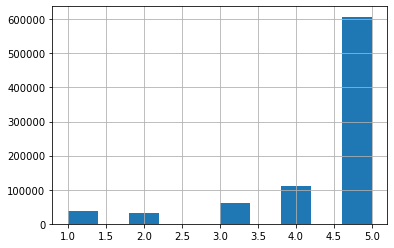

In [18]:
info_col(df_train['overall'], hist=True)

Очень большое количество пятёрок. Пропусков нет.

## verified

In [19]:
info_col(df_train['verified'])

Количество пропусков: 0,

count     847593
unique         2
top         True
freq      736369
Name: verified, dtype: object,

Распределение:
True     736369
False    111224
Name: verified, dtype: int64,



Количество верифицированных отзывов в 7 раз примерно превышает,неверифицированных.Пропусков нет. Заменим значения на 1 и 0.

In [20]:
df_train['verified'] = df_train['verified'].apply(lambda x: 1 if x == True else 0)

Можно посмотреть как отражается распределение оценок на раздичие верификаций

1:  4.479455273103566
0:  4.186920089189384


<AxesSubplot:>

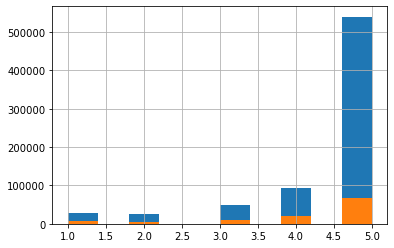

In [21]:
print('1: ',df_train[df_train['verified'] == 1].overall.mean())
df_train['overall'][df_train['verified'] == 1].hist()
print('0: ',df_train[df_train['verified'] == 0].overall.mean())
df_train['overall'][df_train['verified'] == 0].hist()

Средняя оценка у верифицированных пользователей немного выше, но распределение похожее

## reviewTime

In [22]:
info_col(df_train['reviewTime'])

Количество пропусков: 0,

count         847593
unique          4580
top       03 1, 2016
freq             941
Name: reviewTime, dtype: object,

Распределение:
03 1, 2016     941
07 14, 2016    873
06 3, 2015     783
01 20, 2016    783
02 20, 2016    767
              ... 
09 22, 2007      1
04 8, 2006       1
10 2, 2006       1
06 23, 2007      1
05 7, 2006       1
Name: reviewTime, Length: 4580, dtype: int64,



По сути, не нужный столбец, так как есть unixReviewTime. Он более удобен. Можно удалить.

In [23]:
df_train = df_train.drop(['reviewTime'], axis=1)

## reviewerName

In [24]:
info_col(df_train['reviewerName'])

Количество пропусков: 168,

count              847425
unique             101207
top       Amazon Customer
freq                31346
Name: reviewerName, dtype: object,

Распределение:
Amazon Customer    31346
Kindle Customer     6128
Linda                729
John                 714
David                606
                   ...  
Him and Her            1
SARA A MORRISON        1
Dan Mitchell           1
Charleston             1
Anca M                 1
Name: reviewerName, Length: 101207, dtype: int64,



Лидерство занимают отзывы из Amazon и Kindle. Но, скорее всего, этот столбец будет бесполезен

In [25]:
df_train = df_train.drop(['reviewerName'], axis=1)

## reviewText

In [26]:
df_train = df_train.drop(['reviewText'], axis=1)

## summary

Так как этого столбца нет в тестовой выборке, можно удалить.

In [27]:
df_train = df_train.drop(['summary'], axis=1)

## asin

Не догадываюсь, как его испольховать, поэтому удалим.

In [28]:
df_train = df_train.drop(['asin'],axis=1)

## unixReviewTime

Количество пропусков: 0,

count    8.475930e+05
mean     1.441914e+09
std      5.992384e+07
min      9.657792e+08
25%      1.412122e+09
50%      1.449360e+09
75%      1.485130e+09
max      1.538438e+09
Name: unixReviewTime, dtype: float64,

Распределение:
1456790400    941
1468454400    873
1433289600    783
1453248000    783
1455926400    767
             ... 
1144972800      1
1114041600      1
1190419200      1
1161734400      1
1185408000      1
Name: unixReviewTime, Length: 4580, dtype: int64,

AxesSubplot(0.125,0.125;0.775x0.755)


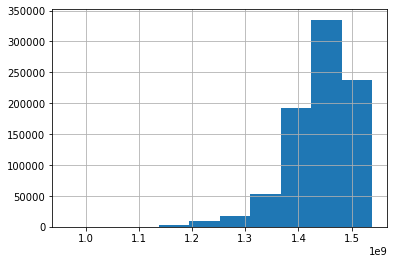

In [29]:
info_col(df_train['unixReviewTime'],hist=True)

In [30]:
Q25 = int(df_train['unixReviewTime'].quantile(0.25))
Q50 = int(df_train['unixReviewTime'].quantile(0.50))
Q75 = int(df_train['unixReviewTime'].quantile(0.75))
print('Самый ранний отзыв:', datetime.utcfromtimestamp(df_train['unixReviewTime'].min()).strftime('%Y-%m-%d %H:%M:%S'))
print('25 квантиль:', datetime.utcfromtimestamp(Q25).strftime('%Y-%m-%d %H:%M:%S'))
print('50 квантиль:', datetime.utcfromtimestamp(Q50).strftime('%Y-%m-%d %H:%M:%S'))
print('75 квантиль:', datetime.utcfromtimestamp(Q75).strftime('%Y-%m-%d %H:%M:%S'))
print('Последний отзыв:', datetime.utcfromtimestamp(df_train['unixReviewTime'].max()).strftime('%Y-%m-%d %H:%M:%S'))

Самый ранний отзыв: 2000-08-09 00:00:00
25 квантиль: 2014-10-01 00:00:00
50 квантиль: 2015-12-06 00:00:00
75 квантиль: 2017-01-23 00:00:00
Последний отзыв: 2018-10-02 00:00:00


В период с 2000-2014 небольшое, возрастающее, количесво отзывов, тут можно обосновать тем, что люди только подсоединялись к сети интернет. Припишем категории к датам.

In [31]:
df_train['unixReviewTime'] = df_train['unixReviewTime'].apply(lambda x:cat_date(x))

## vote

In [32]:
info_col(df_train['vote'])

Количество пропусков: 728732,

count     118861.0
unique       477.0
top            2.0
freq       30774.0
Name: vote, dtype: float64,

Распределение:
2.0      30774
3.0      15336
2        13786
4.0       8893
3         6969
         ...  
316.0        1
385          1
300          1
151          1
238.0        1
Name: vote, Length: 477, dtype: int64,



Исходя из цифр, очень большое кол-во пропусков, в теории, можно удалить данный столбец, но я пока что заменю на нули.

In [33]:
df_train['vote'] = df_train['vote'].fillna(0)

In [34]:
df_train['vote']=df_train['vote'].astype('str').apply(lambda x: x.replace(',',''))
df_train['vote']=df_train['vote'].astype('float').astype('int64')

In [35]:
df_train['vote'] = df_train['vote'].apply(lambda x: cat_vote(x))

## style

In [36]:
info_col(df_train['style'])

Количество пропусков: 407242,

count                      440351
unique                      25892
top       {'Size:': ' Pack of 1'}
freq                         4856
Name: style, dtype: object,

Распределение:
{'Size:': ' Pack of 1'}                                                      4856
{'Package Quantity:': ' 1'}                                                  4526
{'Package Type:': ' Standard Packaging'}                                     3898
{'Size:': ' 1 Pack'}                                                         3848
{'Size:': ' 24 Count'}                                                       3640
                                                                             ... 
{'Flavor:': ' Pure PB'}                                                         1
{'Size:': ' 6.75-ounce bag (pack of 2)'}                                        1
{'Size:': ' 3.5-oz (12 Pack)', 'Style:': ' Spinner Gift Box'}                   1
{'Size:': ' 3.5-Ounce Packages (Pack of 12)', 'Flav

Очень большое кол-во пропусков, думаю, что можно будет удалить данный столбец.

In [37]:
df_train = df_train.drop(['style'],axis=1)

## image_x

Изображение продукта, можно удалить.

In [38]:
df_train = df_train.drop(['image_x'],axis=1)

## userid

In [39]:
info_col(df_train['userid'])

Количество пропусков: 0,

count    847593.000000
mean      53756.091163
std       37211.809152
min           0.000000
25%       20347.000000
50%       48581.000000
75%       84723.000000
max      127495.000000
Name: userid, dtype: float64,

Распределение:
842       427
17987     317
355       302
2024      296
2809      279
         ... 
112150      1
82011       1
32867       1
109270      1
125701      1
Name: userid, Length: 127448, dtype: int64,



Тут всё нормально.

## itemid

In [40]:
info_col(df_train['itemid'])

Количество пропусков: 0,

count    847593.00000
mean      17090.10489
std       11584.74670
min           0.00000
25%        6478.00000
50%       16108.00000
75%       26719.00000
max       41319.00000
Name: itemid, dtype: float64,

Распределение:
22208    5430
23540    4733
24556    4611
379      4252
32046    2449
         ... 
38602       1
40366       1
39236       1
16638       1
6440        1
Name: itemid, Length: 41302, dtype: int64,



Проверим, есть ли пропущенные id

In [41]:
print('Количество уникальных itemid в тренировочном датасете:',len(df_train['itemid'].unique()))
print('Максимальный itemid в тренировочном датасете:',df_train['itemid'].max()+1)

Количество уникальных itemid в тренировочном датасете: 41302
Максимальный itemid в тренировочном датасете: 41320


18 товаров не в датасете, возможно, это как-то повлияет на обучение.

## rating

In [42]:
info_col(df_train['rating'])

Количество пропусков: 0,

count    847593.000000
mean          0.848747
std           0.358296
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: rating, dtype: float64,

Распределение:
1.0    719392
0.0    128201
Name: rating, dtype: int64,



Скорее всего, целевая переменная. Всего 2 значения, понравилось или нет. Нужно глянуть как оценка коррелирует с тем что пользователю понравился товар.

In [43]:
print('Оценки при rating = 0:\n', df_train[df_train['rating'] == 0].overall.value_counts())
print('Оценки при rating = 1:\n', df_train[df_train['rating'] == 1].overall.value_counts())

Оценки при rating = 0:
 3.0    59795
1.0    37071
2.0    31335
Name: overall, dtype: int64
Оценки при rating = 1:
 5.0    607524
4.0    111868
Name: overall, dtype: int64


Выглядит достаточно логично

## category

In [44]:
# Зададим переменной количество категорий
N_CATS = 500

# Создаем пустой список, в который будут добавляться все категории
all_categories = []

# Добавляем категории каждой записи в общий список
for category in df_train['category']:
    all_categories.extend(category)

# Считаем частоту категорий в датасете
cnt = Counter()
for word in all_categories:
    cnt[word] +=1
    
#Оставим топ N_CATS категорий
top_cat = []
for i in range (0, len(cnt.most_common(N_CATS))):
    cat = cnt.most_common(N_CATS)[i][0]
    top_cat.append(cat)
    
# Удаляем дубликаты из all_categories
all_categories = list(dict.fromkeys(all_categories))

print('Всего категорий: ', len(all_categories))
print('Топ', N_CATS, 'категорий: ',top_cat)

Всего категорий:  1003
Топ 500 категорий:  ['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Cooking & Baking', 'Snack Foods', 'Coffee', 'Candy & Chocolate', 'Tea', 'Herbs, Spices & Seasonings', 'Single-Serve Capsules & Pods', 'Bottled Beverages, Water & Drink Mixes', 'Nuts & Seeds', 'Breakfast Foods', 'Canned, Jarred & Packaged Foods', 'Single Herbs & Spices', 'Bars', 'Syrups, Sugars & Sweeteners', 'Green', 'Cooking Oils, Vinegars & Sprays', 'Cereals', 'Produce', 'Jelly Beans & Gummy Candy', 'Breakfast & Cereal Bars', 'Cookies', 'Soups, Stocks & Broths', 'Sauces, Gravies & Marinades', 'Oils', 'Nut Bars', 'Jams, Jellies & Sweet Spreads', 'Candy & Chocolate Bars', 'Hard Candy & Lollipops', 'Roasted Coffee Beans', 'Packaged Meals & Side Dishes', 'Tea Samplers', 'Baking Mixes', 'Chips & Crisps', 'Mixed Spices & Seasonings', 'Ground Coffee', 'Sugar Substitutes', 'Black', 'Salt & Salt Substitutes', 'Dried Fruits & Vegetables', 'Juices', 'Dairy, Cheese & Eggs', 'Dried Fruits', 

In [45]:
# Напишем функцию, которая будет оставлять только топовые категории в списке, остальные удалит
def top_category(categories):
    top_categories = []
    for category in categories:
        if category in top_cat:
            top_categories.append(category)
    x = top_categories
    return x

# Применим функцию к датасету, оставим только топовые категории в столбце category
df_train['category'] = df_train['category'].apply(lambda x: top_category(x))


# Создание dummy-переменных на основе топовых категорий 

# Функция для отображения категорий в записи
def find_item(cell):
    if item in cell:
        return 1
    return 0

# Cоздаем столбцы с категориями и заполняем 0 или 1
for item in top_cat:
    column_name = 'category' + item
    df_train[column_name] = df_train['category'].apply(find_item)

all_categories = None
cnt = None
top_cat = None

Удалим столбец с категориями

In [46]:
df_train = df_train.drop(['category'],axis=1)

## description

Cделаем то же самое, что мы делали для признака reviewText: найдем самые часто встречающиеся слова, оставим только их и подготовимся к созданию dummy-переменных.

In [47]:
df_train['description']

0         [Adobo seasoning (known as adobo seco) is a ve...
1         [Adobo seasoning (known as adobo seco) is a ve...
2         [Adobo seasoning (known as adobo seco) is a ve...
3         [Adobo seasoning (known as adobo seco) is a ve...
4         [Adobo seasoning (known as adobo seco) is a ve...
                                ...                        
847588    [Boyer milk chocolate mallo cups are milk choc...
847589    [Nut butters are NOT all created equal. PB Ame...
847590    [2 Bag Total 4 LBS Roast: Medium, balanced, sm...
847591    [Take a sip of Genesis Today's White Mulberry ...
847592    [, BEACH CLIFF Sardines in Soybean Oil with Ho...
Name: description, Length: 847593, dtype: object

In [48]:
# Зададим переменной количество наиболее частов встречающихся слов, которое хотим оставить
N_WORDS = 200

# Сейчас в поле description список строк. Приведем к единой строке.
df_train['description']=df_train['description'].astype('str')

# Разбиваем description на список слов, предварительно приводим текст к нижнему регистру
df_train['description']=df_train['description'].apply(lambda x: re.sub("[^\w]", " ",  x.lower()).split())
                                        
# Создаем пустой список, в который будут добавляться все слова
all_words = []

# Добавляем слова каждой записи в общий список
for words in df_train['description']:
    # разбиваем текст на слова, предварительно приводим к нижнему регистру
    all_words.extend(words)

# Считаем частоту слов в датасете
cnt = Counter()
for word in all_words:
    cnt[word] +=1
    
#Оставим топ N_WORDS слов
top_words = []
for i in range (0, len(cnt.most_common(N_WORDS))):
    words = cnt.most_common(N_WORDS)[i][0]
    top_words.append(words)
    
# Удаляем дубликаты из all_words
all_words = list(dict.fromkeys(all_words))

print('Всего слов ', len(all_words))
print('Топ', N_WORDS, 'слов: ',top_words)

Всего слов  45025
Топ 200 слов:  ['and', 'the', 'to', 'or', 'of', 'a', 'not', 'in', 'are', 'is', 'for', 'with', 'by', 'have', 'any', 'been', 'health', 'treat', 'intended', 'disease', 'prevent', 'cure', 'dietary', 'diagnose', 'evaluated', 'statements', 'you', 'condition', 'supplements', 'regarding', 'fda', 'that', 'our', 'this', 'organic', 'it', 'from', 'we', 'your', 'as', 'on', 's', 'product', 'tea', 'flavor', 'natural', 'sugar', 'salt', 'oil', 'coffee', 'water', '1', 'ingredients', 'all', 'milk', 'free', 'products', 'may', '2', 'its', 'an', 'chocolate', 'has', 'taste', 'cup', 'can', 'delicious', 'more', 'no', 'contains', 'be', 'made', 'quality', 'use', 'flavors', 'soy', 'flour', 'food', 'information', 'at', 'acid', 'one', 'wheat', 'than', 'whole', 'great', 'powder', 'corn', 'nuts', 'these', '100', 'coconut', 'rice', 'gluten', '3', 'protein', 'enjoy', 'add', 'butter', 'into', 'only', 'just', 'syrup', 'over', 'they', 'blend', 'best', 'their', 'high', 'make', 'sweet', 'perfect', 'also', 

In [49]:
top_word_list = [
    'health',
    'treat',
    'intended',
    'disease',
    'prevent',
    'cure',
    'dietary',
    'diagnose',
    'evaluated',
    'statements',
    'condition',
    'supplements',
    '1',
    'organic',
    'flavor',
    'tea',
    'natural',
    'sugar',
    'salt',
    'water',
    'oil',
    'coffee',
    'ingredients',
    'milk',
    'free',
    'products',
    'chocolate',
    'taste',
    'cup',
    'delicious',
    'quality',
    'flavors',
    'soy',
    'food',
    'flour',
    'acid',
    'wheat',
    'great',
    'powder',
    'corn',
    'nuts',
    'rice',
    'protein',
    'coconut',
    'gluten',
    'butter',
    'syrup',
    'blend',
    'high',
    'best']

In [50]:
# Напишем функцию, которая будет оставлять в списке только слова из top_word_list, остальные удалит
def leave_top_words(words):
    top_words = []
    for word in words:
        if word in top_word_list:
            top_words.append(word)
    x = top_words
    return x

# Применим функцию к датасету, оставим только слова из top_word_list в столбце description
df_train['description'] = df_train['description'].apply(lambda x: leave_top_words(x))


# Создание dummy-переменных на основе слов из top_word_list

# Функция для отображения категорий в записи
def find_item(cell):
    if item in cell:
        return 1
    return 0

# Cоздаем столбцы со словами из top_word_list и заполняем 0 или 1
for item in top_word_list:
    column_name = 'description' + item
    df_train[column_name] = df_train['description'].apply(find_item)
    

all_words = None
cnt = None
top_words = None

In [51]:
df_train = df_train.drop(['description'],axis=1)

## title

Думаю,что его можно будет удалить

In [52]:
df_train = df_train.drop(['title'],axis=1)

## brand

In [53]:
info_col(df_train['brand'])

Количество пропусков: 6104,

count     841489
unique      8866
top         KIND
freq       22506
Name: brand, dtype: object,

Распределение:
KIND                     22506
Bob's Red Mill           13061
Twinings                 11182
Planters                 10384
Frontier                  6926
                         ...  
LOU'S BONSAI  NURSERY        1
Mallo Cup                    1
Novus Tea                    1
Global Healing Center        1
Genesis Today                1
Name: brand, Length: 8866, dtype: int64,



Пропусков относительно не много. 8866 разных производителей. Можно выделить самых известных и сделать для них dummy-переменные

In [54]:
# Зададим переменной количество производителей
N_BRANDS = 50

# Приведем к str
df_train['brand']=df_train['brand'].astype('str')

# Создаем пустой список, в который будут добавляться все производители
all_brands = []

# Добавляем производителя из каждой записи в общий список
for brand in df_train['brand']:
    all_brands.append(brand)

# Считаем количество производителей в датасете
cnt = Counter()
for word in all_brands:
    cnt[word] +=1
    
#Оставим топ N_BRANDS производителей
top_brand = []
for i in range (0, len(cnt.most_common(N_BRANDS))):
    br = cnt.most_common(N_BRANDS)[i][0]
    top_brand.append(br)
    
# Удаляем дубликаты из all_brands
all_brands = list(dict.fromkeys(all_brands))

print('Всего производителей: ', len(all_brands))
print('Топ', N_BRANDS, 'производителей: ',top_brand)

Всего производителей:  8867
Топ 50 производителей:  ['KIND', "Bob's Red Mill", 'Twinings', 'Planters', 'Frontier', 'Green Mountain Coffee Roasters', 'Celestial Seasonings', 'nan', 'McCormick', 'Kirkland Signature', 'Healthworks', 'Simply Organic', "HERSHEY'S", 'Nutiva', 'Quaker', 'produce aisle', 'Viva Naturals', "Campbell's", 'Starbucks', 'Hoosier Hill Farm', 'YumEarth', 'Lipton', 'Food to Live', 'NOW Foods', 'Yogi', 'Sincerely Nuts', 'Stash Tea', 'Torani', 'Harney & Sons', 'Terrasoul Superfoods', "Annie's Homegrown", 'Bragg', 'Lindt', 'Barilla', 'Custom Variety Pack', 'SweetLeaf', 'Folgers', 'Jelly Belly', "Trader Joe's", 'Ghirardelli', 'Bigelow Tea', 'Spicy World', "Davidson's Tea", 'Crazy Cups', "Newman's Own", 'Traditional Medicinals', "Eight O'Clock Coffee", 'Lavazza', 'Keurig', 'Kettle Brand']


In [55]:
# Напишем функцию, которая будет оставлять только топовых производителей, остальных удалит
def leave_top_brand(brands):
    top_brands = []
    for brand in brands:
        if brand in top_brand:
            top_brands.append(brand)
    x = top_brands
    return x

# Применим функцию к датасету, оставим только топовых производителей в стольце brand
df_train['brand'] = df_train['brand'].apply(lambda x: leave_top_brand(x))


# Создание dummy-переменных на основе топовых производителей 

# Функция для отображения производителей в записи
def find_item(cell):
    if item in cell:
        return 1
    return 0

# Cоздаем столбцы с производителями и заполняем 0 или 1
for item in top_brand:
    column_name = 'brand_' + item
    df_train[column_name] = df_train['brand'].apply(find_item)
    
all_brands = None
cnt = None
top_brand = None

In [56]:
df_train = df_train.drop(['brand'],axis=1)

## rank

In [57]:
print('Количество пропусков: {},'.format(df_train['rank'].isnull().sum()))

Количество пропусков: 34598,


Приведем значения данного признака к единому числовому виду

In [58]:
# Приведем все к str
df_train['rank'] = df_train['rank'].astype('str')
# Удалим все значения кроме числовых
df_train['rank'] = df_train['rank'].apply(lambda x: re.sub('\D', '', x))
# Заменим пропуски на высокий ранг (предположим, что чем ниже ранг, тем лучше)
df_train['rank'] = df_train['rank'].apply(lambda x: 9999999 if x == '' else x)
df_train['rank'] = df_train['rank'].astype('float')
# Остаются какие-то большие значения, заменим их на высокий ранг
df_train['rank'] = df_train['rank'].apply(lambda x: 9999999 if x > 9999999 else x)
df_train['rank'] = df_train['rank'].astype('int32')
# Посмотрим на результат
info_col(df_train['rank'])

Количество пропусков: 0,

count    8.475930e+05
mean     6.676660e+05
std      2.289290e+06
min      4.000000e+00
25%      1.094000e+04
50%      4.999900e+04
75%      1.799160e+05
max      9.999999e+06
Name: rank, dtype: float64,

Распределение:
9999999    47163
18          7421
4575        4733
2949        4611
142261      4252
           ...  
655714         1
502857         1
377792         1
304157         1
272257         1
Name: rank, Length: 35977, dtype: int64,



In [59]:
df_train['rank'] = df_train['rank'].apply(lambda x: cat_rank(x))

## also_view

Товары, которые упоминаются, при просмотре других товаров, до конца не догадываюсь, что можно с этим делать, удалю

In [60]:
df_train = df_train.drop(['also_view'],axis=1)

## main_cat

In [61]:
info_col(df_train['main_cat'])

Количество пропусков: 955,

count      846638
unique         17
top       Grocery
freq       802613
Name: main_cat, dtype: object,

Распределение:
Grocery                      802613
Health & Personal Care        31705
Amazon Home                    7383
All Beauty                     1522
Sports & Outdoors              1322
Industrial & Scientific         902
Office Products                 631
Toys & Games                    304
Pet Supplies                    125
Tools & Home Improvement         53
Baby                             34
Arts, Crafts & Sewing            19
Home Audio & Theater              9
Camera & Photo                    8
Musical Instruments               3
Software                          3
Cell Phones & Accessories         2
Name: main_cat, dtype: int64,



Избавимся от пропусков

In [62]:
df_train['main_cat'] = df_train['main_cat'].fillna('Other')

## price

In [63]:
info_col(df_train['price'])

Количество пропусков: 258621,

count     588972
unique      4601
top       $14.99
freq       14241
Name: price, dtype: object,

Распределение:
$14.99              14241
$13.67              10660
$19.99               9043
$14.79               5632
$15.53               5561
                    ...  
$20.33                  2
$6.93                   1
$44.14                  1
$19.99 - $295.00        1
$35.16                  1
Name: price, Length: 4601, dtype: int64,



In [64]:
price = df_train['price'].astype('str').apply(lambda x: re.sub('\D', '', x))
price = price.loc[price!=''].astype('float')
price = price.loc[price<99999]
pr_mean = round(price.mean(),2)
price=None

In [65]:
df_train['price'] = df_train['price'].astype('str').apply(lambda x: re.sub('\D', '', x))

In [66]:
df_train['price'] = df_train['price'].apply(lambda x: pr_mean if x =='' else x).astype('float')
df_train['price'] = df_train['price'].apply(lambda x: pr_mean if x >999999 else x)

In [67]:
info_col(df_train['price'])

Количество пропусков: 0,

count    847593.000000
mean       2069.951567
std        1457.295712
min           1.000000
25%        1398.000000
50%        2069.950000
75%        2112.000000
max       99900.000000
Name: price, dtype: float64,

Распределение:
2069.95    262592
1499.00     14241
1367.00     10660
1999.00      9043
1479.00      5632
            ...  
2848.00         2
3005.00         2
4414.00         1
3516.00         1
693.00          1
Name: price, Length: 4528, dtype: int64,



In [68]:
df_train['price'] = df_train['price'].apply(lambda x: cat_price(x))

## also_buy

Так же как и с "also_view", удаляем.

In [69]:
df_train = df_train.drop(['also_buy'], axis = 1)

## image_y

Картинки, удаляем

In [70]:
df_train = df_train.drop(['image_y'], axis = 1)

## date

In [71]:
info_col(df_train['date'])

Количество пропусков: 835506,

count               12087
unique                417
top       January 1, 2006
freq                  561
Name: date, dtype: object,

Распределение:
January 1, 2006      561
May 5, 2003          428
October 29, 2003     424
January 7, 2008      372
March 10, 2004       294
                    ... 
August 2, 2008         2
December 21, 2007      2
February 13, 2008      1
February 21, 2015      1
January 18, 2008       1
Name: date, Length: 417, dtype: int64,



Очень большое кол-во пропусков, скорее всего нужно удалять.

In [72]:
df_train = df_train.drop(['date'], axis = 1)

## feature

In [73]:
df_train['feature'].loc[df_train['feature'].isna()==False]

982       [64 count of MISS VICKIE'S Kettle Cooked Jalap...
983       [64 count of MISS VICKIE'S Kettle Cooked Jalap...
984       [64 count of MISS VICKIE'S Kettle Cooked Jalap...
985       [64 count of MISS VICKIE'S Kettle Cooked Jalap...
986       [64 count of MISS VICKIE'S Kettle Cooked Jalap...
                                ...                        
847484    [Gourmet Spice Blend | Salt Free, All Natural ...
847504    [Black Tea, 16 Infuser Tea Bags, Re-Sealable S...
847553    [Cajun seasoning, 34-Ounce container, Great to...
847554    [Cajun seasoning, 34-Ounce container, Great to...
847558    [Proper name: Chlorophytum comosum 'Bonnie', G...
Name: feature, Length: 142734, dtype: object

Очень много пропусков, скорее всего нужно будет удалить

In [74]:
df_train = df_train.drop(['feature'], axis = 1)

## details

Сложно представить пока что, что можно тут сделать, думаю, что целесообразнее будет удалить.

In [75]:
df_train = df_train.drop(['details'], axis = 1)

## similar_item

In [76]:
df_train['similar_item'].loc[df_train['similar_item'].isna()==False]

115917    [{'asin': '', 'href': '', 'name': 'DoMatcha - ...
115918    [{'asin': '', 'href': '', 'name': 'DoMatcha - ...
115919    [{'asin': '', 'href': '', 'name': 'DoMatcha - ...
115920    [{'asin': '', 'href': '', 'name': 'DoMatcha - ...
115921    [{'asin': '', 'href': '', 'name': 'DoMatcha - ...
                                ...                        
843729    [{'asin': '', 'href': '', 'name': 'Epoca Silic...
843730    [{'asin': '', 'href': '', 'name': 'Epoca Silic...
843731    [{'asin': '', 'href': '', 'name': 'Epoca Silic...
843732    [{'asin': '', 'href': '', 'name': 'Epoca Silic...
843733    [{'asin': '', 'href': '', 'name': 'Epoca Silic...
Name: similar_item, Length: 1138, dtype: object

Очень много пропусков, нужно удалять

In [77]:
df_train = df_train.drop(['similar_item'], axis = 1)

## tech1

In [78]:
df_train['tech1'].loc[df_train['tech1'].isna()==False]

2779      {'Brand Name': 'Briceo Coffee', 'Item Weight':...
2780      {'Brand Name': 'Briceo Coffee', 'Item Weight':...
2781      {'Brand Name': 'Briceo Coffee', 'Item Weight':...
2782      {'Brand Name': 'Briceo Coffee', 'Item Weight':...
2783      {'Brand Name': 'Briceo Coffee', 'Item Weight':...
                                ...                        
841681    {'Brand Name': 'Twinings', 'Item Weight': '8 o...
842662    {'Brand Name': 'Nestle Coffee Mate', 'Item Wei...
842663    {'Brand Name': 'Nestle Coffee Mate', 'Item Wei...
846645    {'Brand Name': 'Green & Black's', 'Item Weight...
846646    {'Brand Name': 'Green & Black's', 'Item Weight...
Name: tech1, Length: 4372, dtype: object

Очень много пропусков, нужно удалять

In [79]:
df_train = df_train.drop(['tech1'], axis = 1)

## fit

Очень много пропусков, нужно удалять

In [80]:
df_train = df_train.drop(['fit'], axis = 1)

## Анализ признаков

Мы видим, что осталось обработать 10 категориальных признаков, из которых

3 шт. (userid, itemid, rating) мы не трогаем

признак overall отсутствует в тестовом датасете

а для остальных 6 (verified, unixReviewTime, vote, rank, main_cat, price) можем сделать dummy-переменные.

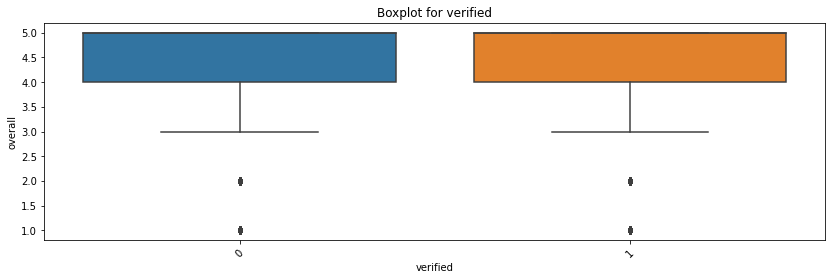

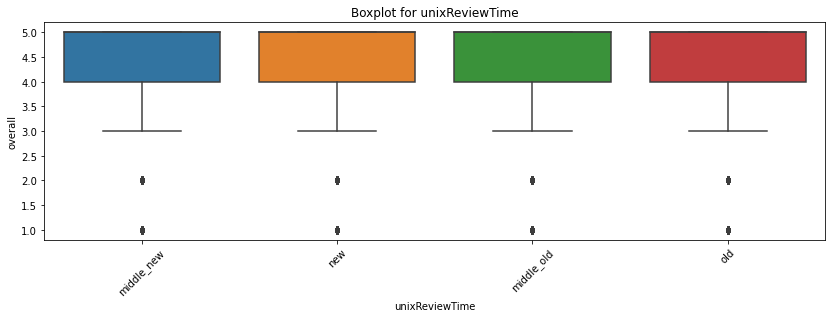

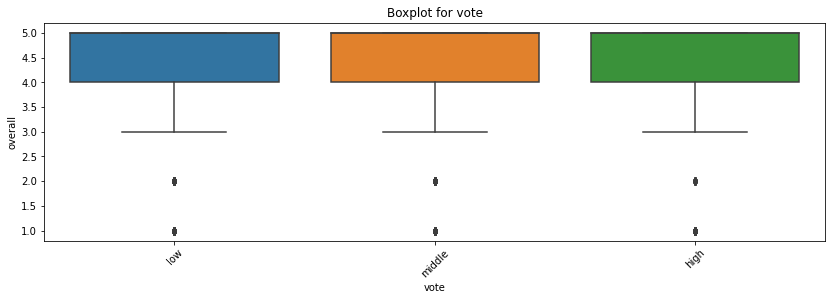

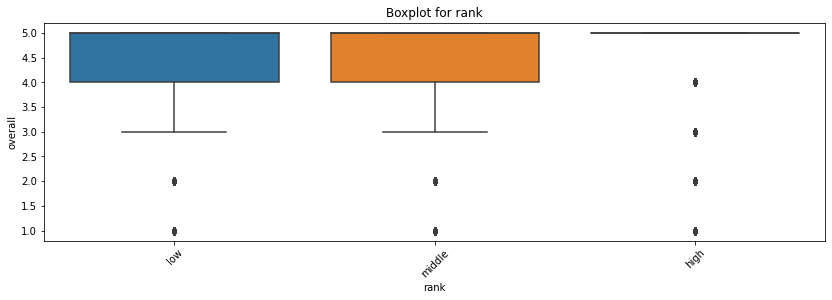

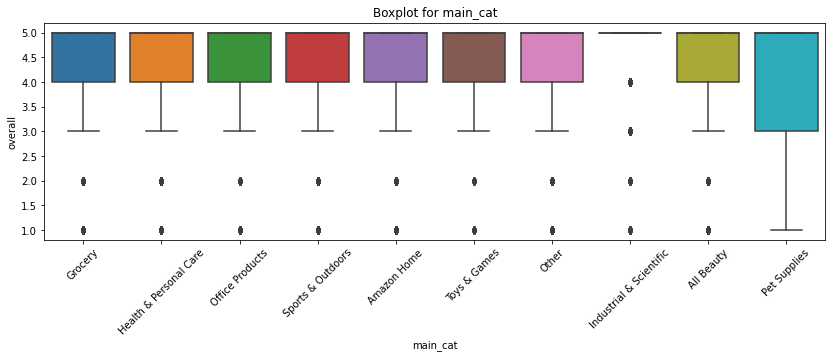

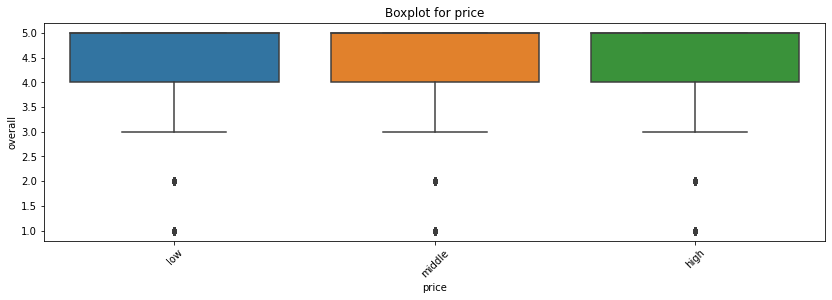

In [81]:
for col in ['verified', 'unixReviewTime', 'vote', 'rank', 'main_cat', 'price']:
    get_boxplot(col)

По графикам сильных различий не видно. Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения оценок пользователей по различным параметрам неразличимы:

In [82]:
for col in ['verified', 'unixReviewTime', 'vote', 'rank', 'main_cat', 'price']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки verified
Найдены статистически значимые различия для колонки unixReviewTime
Найдены статистически значимые различия для колонки vote
Найдены статистически значимые различия для колонки rank
Найдены статистически значимые различия для колонки main_cat
Найдены статистически значимые различия для колонки price


Распределение оценок серьезно различается по всем шести параметрам.

In [83]:
df_train = df_train.drop(['overall'], axis = 1)

## Обучение модели

Разделим тренировочный датасет на тренировочную и тестовую выборки

In [84]:
train_data, test_data = train_test_split(df_train,random_state=42, shuffle=True)

In [85]:
train_data.shape, test_data.shape

((635694, 609), (211899, 609))

Чтобы работать с моделями в библиотеке LightFm, нам нужно создать разреженные матрицы. Мы будем хранить данные в формате COO (координатный формат представления данных). Вместо хранения всех значений, которые включают нулевые значения, мы будем хранить только ненулевые значения. В COO данные представлены в виде (строка, столбец, значение).

In [86]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'],)))

In [87]:
LR = 0.089
NUM_THREADS = 20  # число потоков
NUM_COMPONENTS = 300  # число параметров вектора
NUM_EPOCHS = 30  # число эпох обучения
LEARNING_SCHEDULE = 'adagrad'
LOSS_FUNCTION = 'logistic'
RANDOM_STATE = 42

model = LightFM(learning_rate=LR,
                loss=LOSS_FUNCTION,
                no_components=NUM_COMPONENTS,
                learning_schedule=LEARNING_SCHEDULE,
                random_state=RANDOM_STATE)

model = model.fit(ratings_coo,
                  epochs=NUM_EPOCHS,
                  num_threads=NUM_THREADS)

Получим предсказания

In [88]:
preds = model.predict(test_data['userid'].values,
                      test_data['itemid'].values)

Посчитаем метрику roc_auc_score

In [89]:
sklearn.metrics.roc_auc_score(test_data['rating'],preds)

0.7370675618834893

Вцелом неплохо, осталось только доделать submission на kaggle

# Вывод

Был произведён EDA, генерация признаков и обучение модели. Получил скор 0.74745. Таким образом, удалось достичь определённых успехов.